In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_vgg_model(input_shape, num_classes):
    # Load the VGG16 model with pre-trained weights, excluding the top classification layer
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    base_model.trainable = False
    # Create the model
    model = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  
    ])
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.summary() 
    return model

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_custom_cnn(input_shape=(65, 65, 1), num_classes=2):
    model = models.Sequential()

    # 1st Conv2D layer
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(layers.Activation('relu'))

    # 1st MaxPooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 2nd Conv2D layer
    model.add(layers.Conv2D(32, (5, 5), padding='valid'))
    model.add(layers.Activation('relu'))

    # 2nd MaxPooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # 3rd Conv2D layer
    model.add(layers.Conv2D(16, (5, 5), padding='valid'))
    model.add(layers.Activation('relu'))

    # 3rd MaxPooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Flatten layer
    model.add(layers.Flatten())

    # Dropout layer
    model.add(layers.Dropout(0.5))

    # Dense layer with 128 units
    model.add(layers.Dense(128))
    model.add(layers.Activation('relu'))

    # Dense layer with 50 units
    model.add(layers.Dense(50))
    model.add(layers.Activation('relu'))

    # Output layer with num_classes units
    model.add(layers.Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

    return model

# Example usage:
# model = create_custom_cnn(input_shape=(65, 65, 1), num_classes=2)
# 


In [2]:
def prepare_data(train_dir, val_dir, image_size, batch_size):
    
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,          # Rotate images randomly up to 20 degrees
        width_shift_range=0.2,      # Shift images horizontally by 20% of the width
        height_shift_range=0.2,     # Shift images vertically by 20% of the height
        shear_range=0.2,            # Shear transformation
        zoom_range=0.2,             # Zoom in on images by up to 20%
        horizontal_flip=True,       # Randomly flip images horizontally
        fill_mode='nearest'         # Fill in missing pixels after transformation
    )
    
    val_datagen = ImageDataGenerator(
        rescale=1./255
    )
    
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical' if more than two classes
    )
    
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'  # Change to 'categorical' if more than two classes
    )
    
    return train_generator, val_generator


In [3]:
print(tf.config.list_physical_devices("GPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from PIL import Image

# Define parameters
input_shape = (100, 100, 3)
image_size = (100,100)
batch_size = 64
epochs = 50
num_classes = 3  # Change to the number of classes if more than two (binary classification)

train_dir = 'Multiclass\Scale_100\Training'
val_dir = 'Multiclass\Scale_100\Validation'


# Create model
model = create_custom_cnn(input_shape, num_classes)

# Prepare data
train_generator, val_generator = prepare_data(train_dir, val_dir, image_size, batch_size)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('VGG_Multi_100x100.h5', monitor='val_loss', save_best_only=True, mode='min')

callbacks = [reduce_lr, early_stop, model_checkpoint]

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 activation (Activation)     (None, 100, 100, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 23, 23, 32)       0         
 2D)                                                  

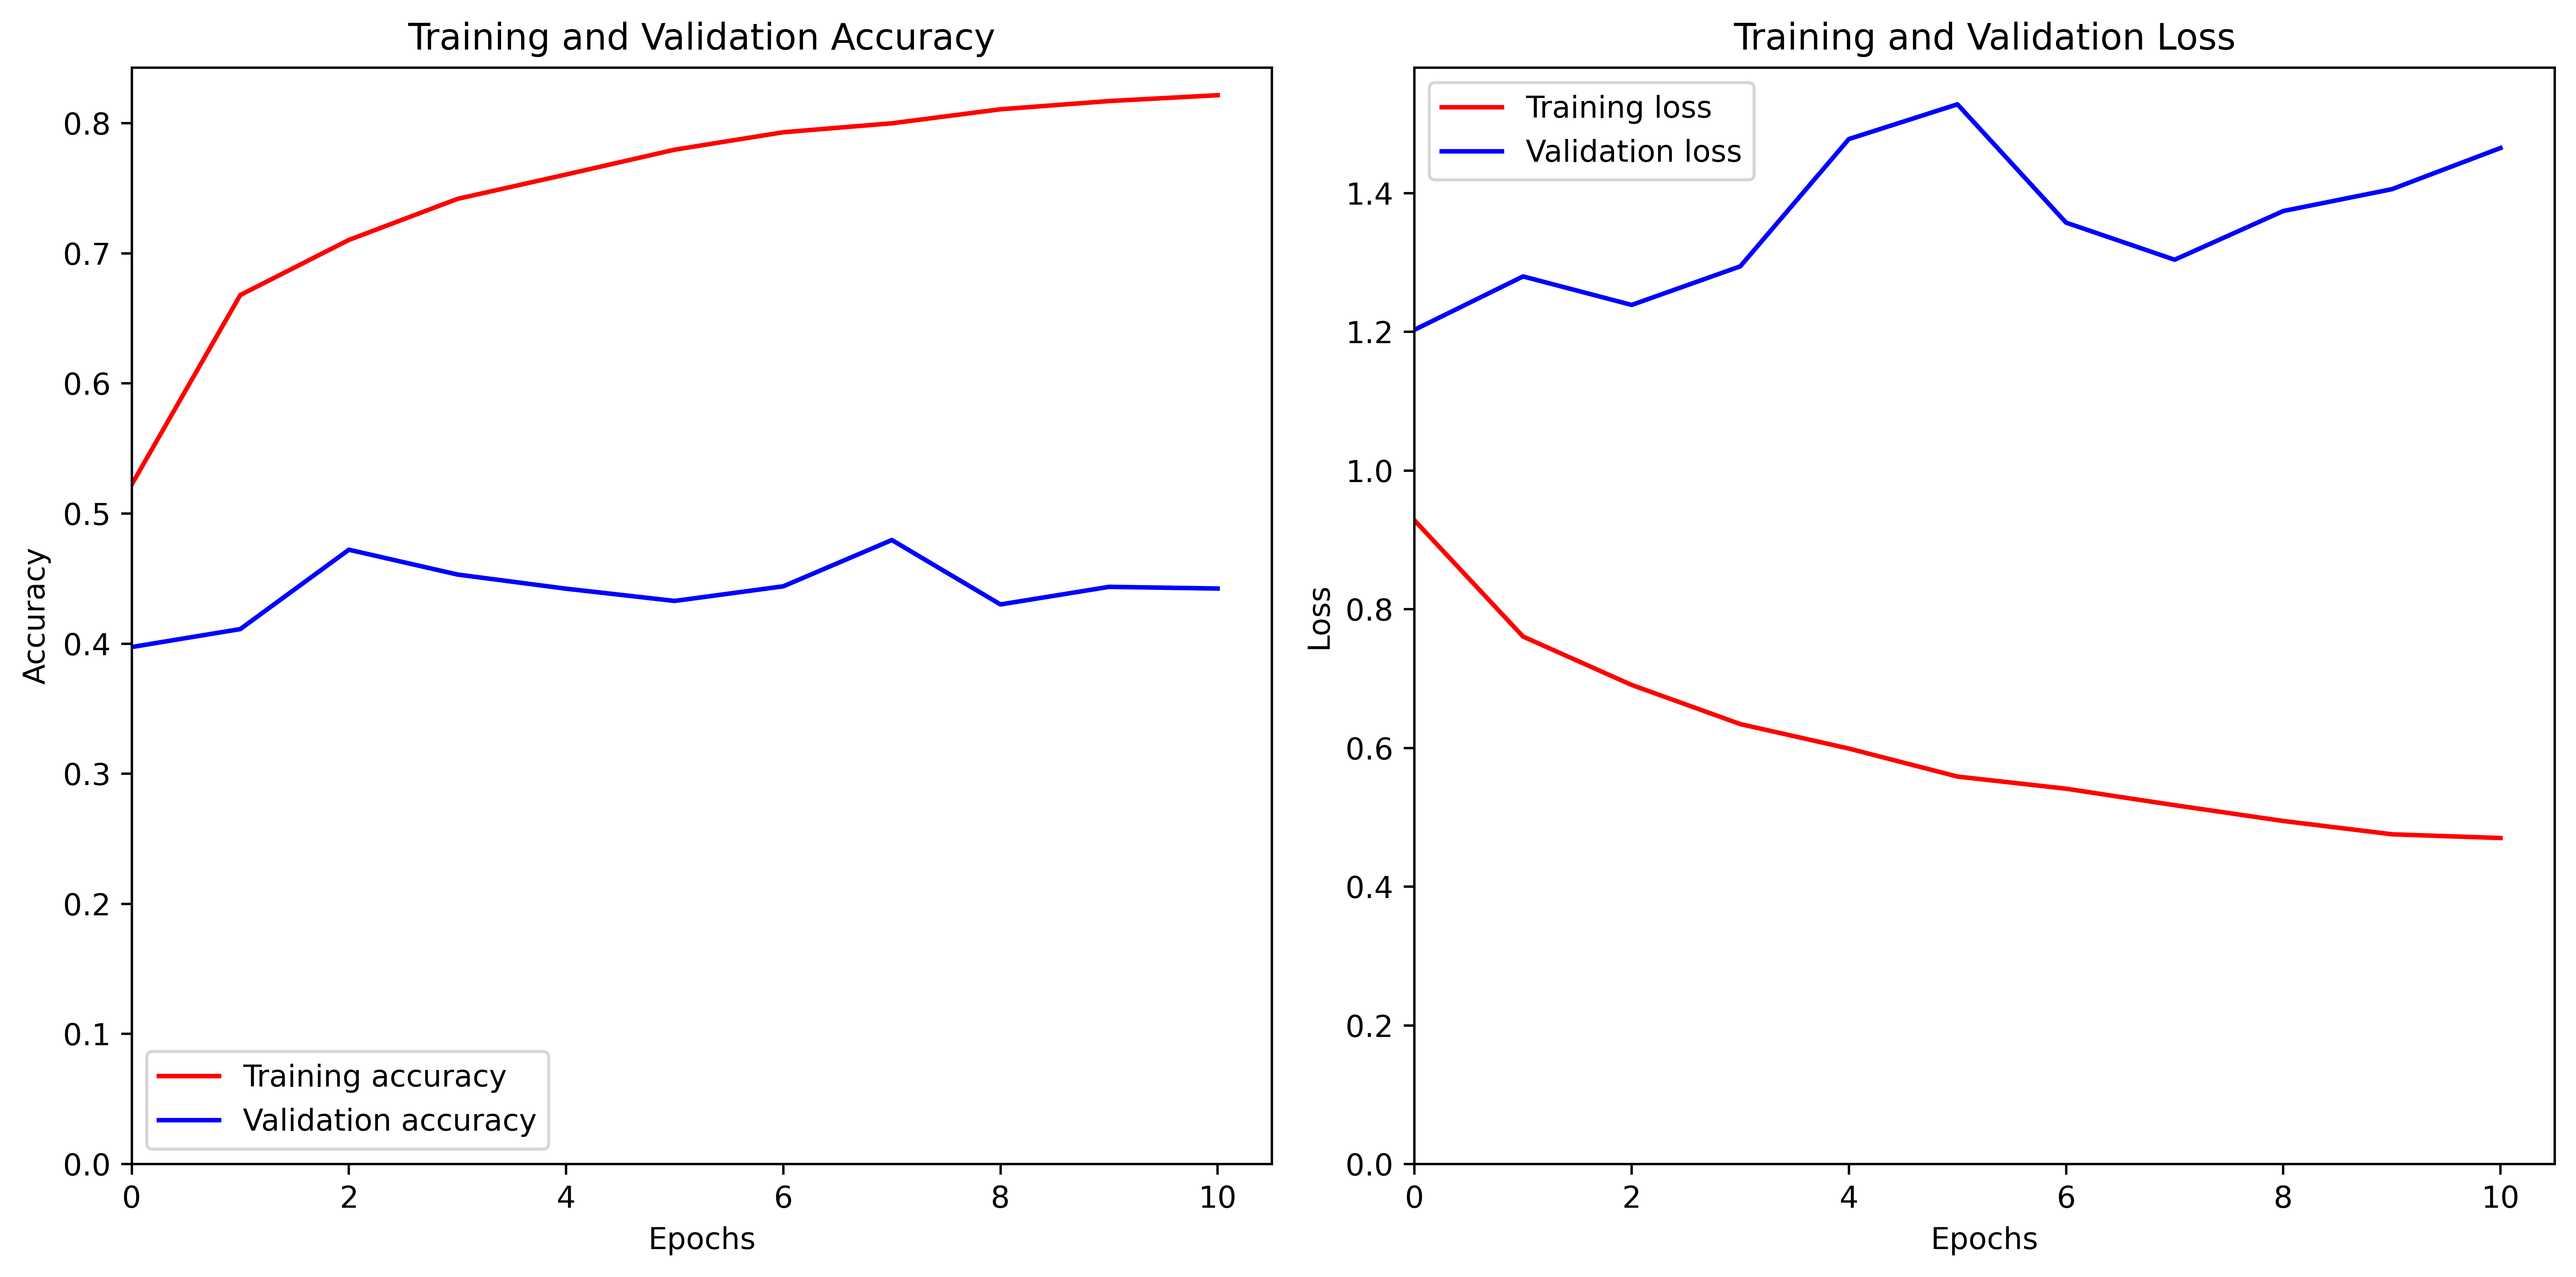

In [ ]:
import matplotlib.pyplot as plt

def plot_accuracy(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 6),dpi = 550)
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim(left=0)  # Start x-axis from 0
    plt.ylim(bottom=0)  # Start y-axis from 0

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim(left=0)  # Start x-axis from 0
    plt.ylim(bottom=0)  # Start y-axis from 0

    plt.tight_layout()
    plt.show()

# Call the plot function
plot_accuracy(history)
